# HOG & SVM for digit Classification

### Introduction
*In this notebook, I am trying to classify digits from MNIST digit dataset using SVM which is trained using HOG Features.*

### Step 1: Importing Necessary Packages

In [22]:
import cv2
import os
import tqdm
import pickle
import numpy as np
from mnist import MNIST
import matplotlib.pyplot as plt
from sklearn import svm

### Step 2: Structuring HOG Descriptor

In [23]:
def initializeHog():
    # Initializing hog parameters
    winSize = (28,28)
    blockSize = (8,8)
    blockStride = (4,4)
    cellSize = (4,4)
    nbins = 9
    # derivAperture = -1
    # winSigma = -1
    # histogramNormType = 1
    # L2HysThreshold = 0.2
    # gammaCorrection = False
    # nlevels = 64
    # signedGradient = False
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    return hog

def getHOGdescriptor(path, test=False, samples=200, startIndex=0):
    # By default, process descriptors for traning dataset, otherwise test dataset
    
    mndata = MNIST(path)
    
    if test:
        images, labels = mndata.load_testing()
    else:
        images, labels = mndata.load_training()
        samples = max(samples, len(images))# Train on all data
    
    # Convert to numpy arrays and reshape all images
    images = [np.array(image, dtype=np.uint8).reshape(28,28) for image in images]; 
    print("Converted {} Images to Numpy Arrays . . .".format(len(images)))
    
    print("Calculating HOG Features . . .")
    
    HOG_FeatureVectors = []; givenlabels = [] # Corresponding to each feature vector
    hog = initializeHog() # Initialize HOG
    
    for i in tqdm.tqdm(range(len(images[startIndex:samples]))):
        
        image = images[i]; label = labels[i];
        
        descriptor = hog.compute(image)
        HOG_FeatureVectors.append(descriptor.reshape(-1))
        givenlabels.append(label)
    
    print('Returned total descriptors: {} & total labels: {}'.format(len(HOG_FeatureVectors), len(givenlabels)))
    
    return HOG_FeatureVectors, givenlabels

### Step 3: Training our model using Support Vector Machines

In [18]:
def trainSVM(path):
    HOG, Labels = getHOGdescriptor(path, False)
    
    # SVM Model
    model = svm.SVC(kernel="rbf", C=30.0, gamma='scale')
    model.fit(HOG, Labels)
    
    return model

In [24]:
datasetPath = "../CV_Datasets/MNIST/Digits"
model = trainSVM(datasetPath)

  5%|▌         | 3113/60000 [00:00<00:01, 31129.21it/s]

Converted 60000 Images to Numpy Arrays . . .
Calculating HOG Features . . .


100%|██████████| 60000/60000 [00:02<00:00, 24753.58it/s]


Returned total descriptors: 60000 & total labels: 60000


### Step 4: Testing our model

In [27]:
def testModel(path, model, threshold=0.95, name="modelSVM"):
    HOG, Labels = getHOGdescriptor(path, True, 1000) # Test on thousand images
    print("Evaluating Model . . .")
    result = model.score(HOG, Labels)
    print("Model accuracy: {}%".format(result*100))
    
    if result >= threshold:
        name = name + str(result*100)[:2] + ".sav"
        pickle.dump(model, open(name, 'wb'))
        print("Model saved as : {}".format(name))
        
testModel(datasetPath, model, 0.90)

100%|██████████| 1000/1000 [00:00<00:00, 29986.52it/s]

Converted 10000 Images to Numpy Arrays . . .
Calculating HOG Features . . .
Returned total descriptors: 1000 & total labels: 1000
Evaluating Model . . .


Model accuracy: 99.1
Model saved as : modelSVM99.sav


### Step 5: Display Results

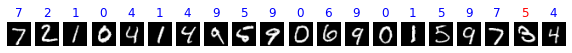

In [41]:
def displayModelResults(path, model, no_of_samples=20):
    
    mndata = MNIST(path)
    images, labels = mndata.load_testing()
    images = [np.array(image, dtype=np.uint8).reshape(28,28) for image in images]; # Convert to numpy arrays and reshape all images
    
    # Display Dataset
    plt.figure(figsize=[10,10])
    cols = no_of_samples
    rows = 1
    
    hog = initializeHog()

    for i in range(int(cols*rows)):
        image = np.array(images[i]); trueLabel = labels[i]
        descriptor = hog.compute(image)
        predictedLabel = model.predict(descriptor.reshape(1,-1))[0]
        if (predictedLabel == trueLabel):
            color = 'b'
        else:
            color = 'r'

        plt.subplot(rows,cols,i+1);
        plt.imshow(image, cmap="gray");
        titleObj = plt.title(str(predictedLabel));
        plt.setp(titleObj, color=color) 
        plt.axis('off')
    return

displayModelResults(datasetPath, model)

### Load Saved Model

In [21]:
# model = pickle.load(open("modelSVM970.sav", 'rb')) # Replace ... with file name of the model